In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from qids_lib import QIDS
import numpy as np
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
from pipeline import Dataset, backtest
from matplotlib import pyplot as plt
from datatools import data_quantization, check_dataframe, extract_market_data
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm, trange
from pandas import Series, DataFrame, MultiIndex
from visualization.metric import Performance
from sklearn.metrics import r2_score
from visualization.metric import plot_performance
from qids_lib import QIDS
from sklearn.preprocessing import MinMaxScaler

In [5]:
dataset = Dataset.load('../../data/parsed')

In [3]:
qids = QIDS(path_prefix='../../')

In [4]:
class LSTM(nn.Module):

    def __init__(self, num_output, num_features,
                 hidden_size, num_layers):
        ## hidden_size is like embedding feature space dimension
        ## better > num_assets?
        ## if num_layers = 2: stack 2 LSTM of lyaer 1:
        # nn.Sequential(OrderedDict([
        #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
        #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
        #     ]))
        super(LSTM, self).__init__()
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # self.window_size = window_size

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        # the second dim for h_0 and c_0 is the batch dim
        # hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)
        # cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1,:,:].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out


In [77]:
class NN_wrapper():
    def __init__(self, net_path, lookback_window, optimizer,
                 num_features, learning_rate = 0.003,
                 criterion = nn.MSELoss(), n_epoch = 3):

        self.net =  LSTM(num_output=1, #only the return
           num_features=num_features,
             hidden_size=1024, num_layers=1)
        self.net.load_state_dict(torch.load(net_path))
        self.lookback_window = lookback_window
        self.learning_rate = learning_rate
        self.criterion = criterion
        if optimizer == 'LBFGS':
            self.optimizer = optim.LBFGS(self.net.parameters(), lr=learning_rate)
        elif optimizer == 'ADAM':
            self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
        else:
            raise ValueError('Optimizer not supported')
        self.optim_name = optimizer
        self.n_epoch = n_epoch

    def fit(self, X, y):
        self.net.train()
        torch.manual_seed(3407)
        scaler = MinMaxScaler()
        #compute known return
        # print(X.query("day=='986'"))
        X['return_0+1'] = X['return_0']*X['return_1']+X['return_0']+X['return_1']
        X = X.drop(columns=['return_0', 'return_1'])
        X_np = X.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)

        X_np = scaler.fit_transform(X_np)


        for epoch in range(self.n_epoch):
            for i in range(int(X.shape[0]/54 - self.lookback_window)+1):
                ## use continuous days as look back e.g. if lookback=2 days=[2,3,4,5]
                ## then loop over: [2,3], [3,4], [4,5]
                # print('look back day:', int(X.shape[0]/(self.lookback_window*54)))
                X_np_day = X_np[i:(i+1)*self.lookback_window*54, :]

                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_tensor = X_np_day.reshape(54,self.lookback_window,-1)
                # dim (batch, days, features)
                X_torch = torch.from_numpy(X_np_tensor)
                # print(y.shape)
                y_day = y.to_numpy().astype(np.float32)[i:(i+1)*self.lookback_window*54]
                labels = torch.tensor(y_day[-54:]).to(torch.float)
                # print('its actually training')
                def closure():
                    self.optimizer.zero_grad()
                    outputs=self.net(X_torch)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    return loss
                self.optimizer.zero_grad()
                outputs = self.net(X_torch)
                loss = self.criterion(outputs.squeeze(), labels)
                loss.backward()
                if self.optim_name == 'LBFGS':
                    self.optimizer.step(closure) # need closure for LBFGS
                else:
                    self.optimizer.step()
        return


    def predict(self, X):
        self.net.eval()
        # print(X)
        torch.manual_seed(3407)
        scaler = MinMaxScaler()
        #compute known return
        X['return_0+1'] = X['return_0']*X['return_1']+X['return_0']+X['return_1']
        X = X.drop(columns=['return_0', 'return_1'])

        X_np = X.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
        # shape (asset, days, feature) -> (ft, days, asset)
        X_np = scaler.fit_transform(X_np)
        X_np_tensor = X_np.reshape(54,self.lookback_window,-1)
        # X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
        X_torch = torch.from_numpy(X_np_tensor)
        y = self.net(X_torch)
        return np.clip(y.squeeze().detach().numpy(), -0.2, 0.2)

In [78]:
net_path = '../../model/dump/LSTM_1for54'
train_lookback = 16
eval_lookback = 16
n_epoch = 1
lr = 5e-5
criterion = nn.MSELoss()
# optimizer = 'LBFGS'
optimizer = 'ADAM'
# df = pd.concat([dataset.fundamental, dataset.ref_return], axis=1).dropna()
# check_dataframe(df, expect_index=['day', 'asset'])
# df['return_0+1'] = df['return'].shift(2 * 54).fillna(0)

In [79]:
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'return_0',
                    'return_1']
from pipeline.backtest import evaluation_for_submission
performance = evaluation_for_submission(NN_wrapper(net_path, eval_lookback, num_features=8, optimizer=optimizer, learning_rate = lr,
                                                   criterion=criterion),
                                        feature_columns=original_feature,
                                        dataset=dataset, df=dataset.fundamental, qids=qids, lookback_window=train_lookback,
                                        eval_lookback_window=eval_lookback)

/Users/lewisliu/Desktop/Study/Graduate_Study_Austin/Career/Practice/qids-2023-comp/pipeline/backtest.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return_list.append(return_0.groupby(level=1).apply(lambda df: df.shift(i).bfill()).rename(f'return_{i}'))
/Users/lewisliu/Desktop/Study/Graduate_Study_Austin/Career/Practice/qids-2023-comp/pipeline/backtest.py:163: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -7.6097e-01
The ending score for metric test_cum_pearson is: -1.1117e-02


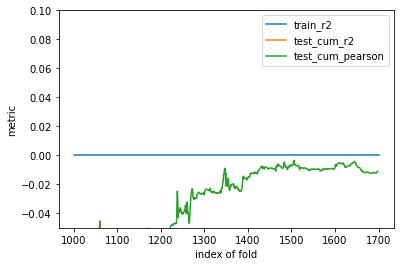

In [73]:
# train 3 epoch
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()


The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -6.1708e-02
The ending score for metric test_cum_pearson is: 7.6011e-03


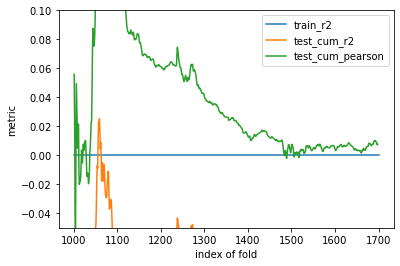

In [76]:
# no training
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric test_cum_r2 is: -7.1084e-01
The ending score for metric test_cum_pearson is: 4.4605e-03


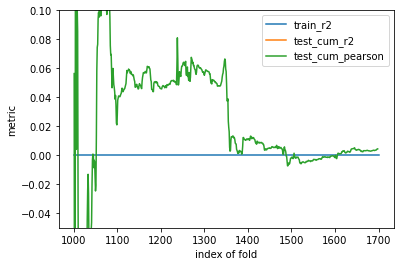

In [80]:
# train 1 epoch
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
# plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

In [32]:
a1 = -0.019765
a2 =  0.004224
a1*a2 + a1+a2

-0.01562448736

In [33]:
a1 = -0.005840
a2 =   -0.016288
a1*a2 + a1+a2



-0.02203287808

In [81]:

fundamental_df = dataset.fundamental

In [82]:
df_np = fundamental_df.to_numpy().astype(np.float32)

In [83]:
df_np = df_np.reshape(54,-1,7)